# Fake News Classifier 
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable (1: unreliable, 0: reliable)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import matplotlib.pyplot as plt

## Text preprocessing

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.shape

(20800, 5)

In [4]:
## Get the independent features
X = df.drop('label', axis=1)
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [5]:
## Get the dependent features
y = df['label']
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [6]:
## drop observations with missing values 
df = df.dropna()
df.shape


(18285, 5)

In [7]:
messages = df.copy()
messages.reset_index(inplace=True) # reset index as some observations is dropped and index is not continuous anaymore 

In [8]:
## Clean and preprocessing title by removing syntax other than letter and stopwords 
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### BOW: Bag of words

In [9]:
## Create the Bag of Words model 
cv = CountVectorizer(max_features=5000, ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
X.shape

(18285, 5000)

In [10]:
cv.get_feature_names_out()[:10]

array(['aaron', 'abandon', 'abc', 'abe', 'abedin', 'abil', 'abl', 'abort',
       'abroad', 'absenc'], dtype=object)

In [11]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [12]:
y = messages['label']

In [13]:
## Train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
count_df = pd.DataFrame(X_train, columns = cv.get_feature_names_out())
count_df.head()

,aaron,abandon,abc,abe,abedin,abil,abl,abort,abroad,absenc,...,young,young peopl,younger,youth,youtub,zero,zika,zionist,zone,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
## Give definition of plotting confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## MultinomialNB Algorithm

In [16]:
from sklearn import metrics
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.897
Confusion matrix, without normalization


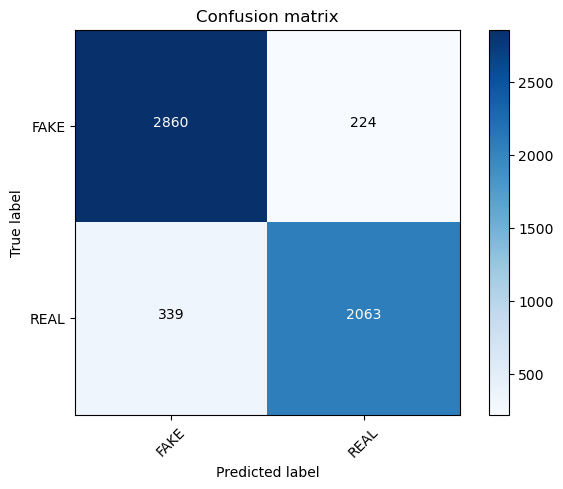

In [17]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [18]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.8973751367116296

## Multinomial Classifier with Hyperparameter

In [19]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Alpha: 0.0, Score : 0.5621582209259934
Alpha: 0.1, Score : 0.8979219832300401
Alpha: 0.2, Score : 0.8975574188844331
Alpha: 0.30000000000000004, Score : 0.8975574188844331
Alpha: 0.4, Score : 0.8973751367116296
Alpha: 0.5, Score : 0.8973751367116296
Alpha: 0.6000000000000001, Score : 0.8973751367116296
Alpha: 0.7000000000000001, Score : 0.8973751367116296
Alpha: 0.8, Score : 0.8973751367116296
Alpha: 0.9, Score : 0.8973751367116296


alpha = 0.1 gives result highest accuracy. 

In [20]:
classifier=MultinomialNB(alpha=0.1)

In [21]:
## Get Features names
feature_names = cv.get_feature_names_out()
## Most real
sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:20]

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

In [ ]:
### Most fake
sorted(zip(classifier.feature_log_prob_[0], feature_names))[:20]

[(-15.092333186164353, 'auf'),
 (-15.092333186164353, 'en el'),
 (-15.092333186164353, 'fli zone'),
 (-15.092333186164353, 'html'),
 (-15.092333186164353, 'http co'),
 (-15.092333186164353, 'http www'),
 (-15.092333186164353, 'infowar life'),
 (-15.092333186164353, 'pic twitter com'),
 (-15.092333186164353, 'ufo'),
 (-15.092333186164353, 'utm'),
 (-14.345118784334131, 'brain forc'),
 (-14.345118784334131, 'como'),
 (-14.345118784334131, 'ein'),
 (-14.345118784334131, 'infowar com'),
 (-14.345118784334131, 'ist'),
 (-14.345118784334131, 'oligarchi'),
 (-14.345118784334131, 'twitter com'),
 (-14.345118784334131, 'una'),
 (-14.345118784334131, 'zu'),
 (-13.922261933514099, 'kadzik')]

## Passive Aggressive Classifier Algorithm

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

accuracy:   0.937
Confusion matrix, without normalization


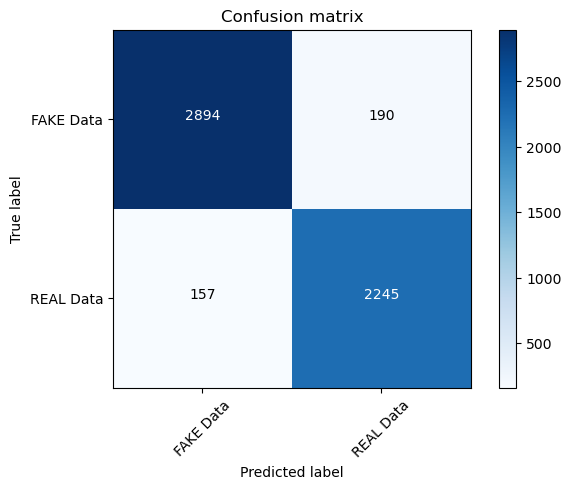

In [ ]:
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

## Introduce TF-IDF model for Text instead of Title 

In [22]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ common licens apolog keith olbermann doubt worst person world week fbi director jame comey accord hous democrat aid look like also know second worst person well turn comey sent infam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe hear comey found via tweet one republican committe chairmen know comey notifi republican chairmen democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen jason chaffetz jasoninthehous octob cours know case comey actual say review email light unrel case know anthoni weiner sext teenag appar littl thing fact matter ch

In [23]:
messages['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [24]:
tfidf_v = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()

In [32]:
y = messages['label']

## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

accuracy:   0.880
Confusion matrix, without normalization


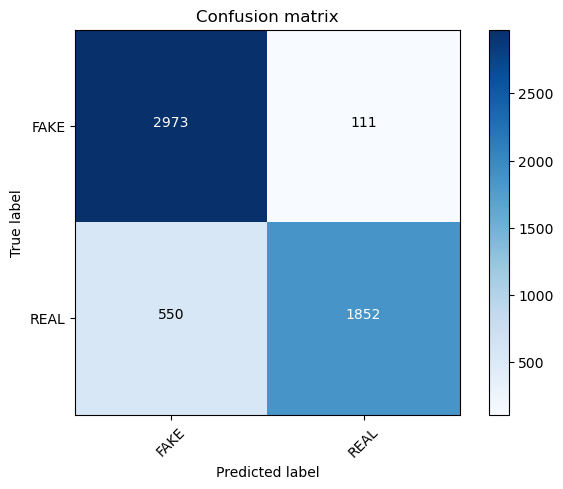

In [33]:
## MultinomialNB Algorithm
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [34]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
score

0.8795114837768866

accuracy:   0.921
Confusion matrix, without normalization


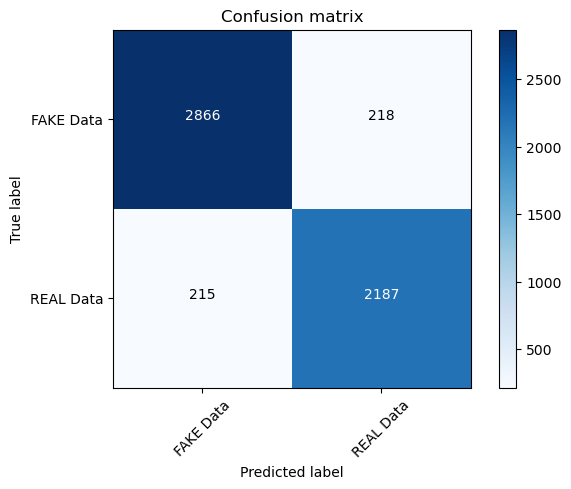

In [35]:
## Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

## HashingVectorizer

In [36]:
hs_vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)
X = hs_vectorizer.fit_transform(corpus).toarray()

accuracy:   0.877
Confusion matrix, without normalization


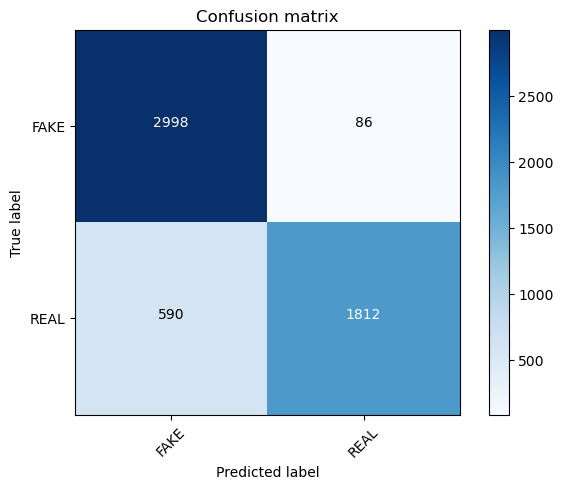

In [38]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])